# Short introduction to my Sentiment analysis work.
## (Public polarity on cryptocurrency)

### Pierre B. Regenpied 

This notebook is an introduction to the work I am doing during my Summer Internship at Mazars, the goal is to retrieve open source data on bitcoin and try to get an analysis of public sentiment. 

The data we are using are Tweets, however my intuition was that tweets would be too noisy, so we started by scraping tweets listed on cryptopanic.com, a site with a community of crypto-analysts. 

These tweets are evaluated according to their seriousness and potential impact, that way, it allows us to avoid web trolls or other bad data. 

In [1]:
import pandas as pd
from textblob import TextBlob
import time
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os

In [2]:
#os.system("python cryptopanic_scraper.py --headless --limit 1000 --filter hot")

    output:

    Initializing chromedriver.


    Checking for mac64 chromedriver:91.0.4472.101 in cache
    Loading News Feed...

    Loading 48 more rows
    Loading 43 more rows
    Loading 46 more rows
    No more rows to load :/
    Total rows loaded: 190

    Downloading Data...

    Time Start: 2021-07-01 16:34:58.823832

    Downloaded 10
    Downloaded 20
    Downloaded 30
    Downloaded 40
    Downloaded 50
    Downloaded 60
    Downloaded 70
    Downloaded 80
    Downloaded 90
    Downloaded 100
    Downloaded 110
    Downloaded 120
    Downloaded 130
    Downloaded 140
    Downloaded 150
    Downloaded 160
    Downloaded 170
    Downloaded 180
    Finished gathering 183 rows of data

    Time End: 2021-07-01 16:41:20
    Elapsed Time Gathering Data: 0:06:21

    Saved data to cryptopanic_all_Wed Jun 30->Thu Jul 01.pickle
    

In [3]:
if os.name == 'posix': #osx / linux
    !ls data
elif os.name =='nt': #windows
    !dir data

Binance_BTCUSDT_d.csv
cryptopanic_all_Wed Jun 30->Thu Jul 01.pickle
cryptopanic_hot_Mon Jun 28->Thu Jul 01.pickle


In [4]:
def to_ts(date):
    """
    Converts a dd/mm/yy or yy-mm-dd date format to a timestamp
    ============
    Input  : str
    Output : int
    """
    if '/' in date: #Format dd/mm/yy
        return int(time.mktime(datetime.datetime.strptime(date, "%d/%m/%Y").timetuple()))
    elif '-' in date: #Format yy-mm-dd
        return int(time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple()))

def to_date(ts):
    """
    Converts a timestamp to a yy-mm-dd format date
    ============
    Input  : int
    Output : str
    """
    return str(datetime.datetime.fromtimestamp(ts)).split(' ')[0]

min_ = 1621720800
max_ = 1623016800

print(to_date(min_))
print(to_date(max_))

2021-05-23
2021-06-07


In [5]:
#Obtenu en runnant le script cryptopanic_scraper.py
obj = pd.read_pickle('data/cryptopanic_hot_Mon Jun 28->Thu Jul 01.pickle')

In [6]:
Dates, Tweets = list(), list()
for key in obj.keys():
 
    month,day = obj[key]['Date'].split(' ')[1:3]
    Dates.append(to_ts("%s/%s/%s"%(day,month.replace('Jun','06').replace('Jul','07'),'2021')))
    Tweets.append(obj[key]['Title'].lower())


In [7]:
tweet = TextBlob("Textblob is amazingly simple to use. What great fun!")
Subjectivities = [TextBlob(Tweet).sentiment.subjectivity for Tweet in Tweets]
Polarities = [TextBlob(Tweet).sentiment.polarity for Tweet in Tweets]

In [8]:
df = pd.DataFrame()
df['Tweet'] = Tweets
df['Date'] = Dates
df['Polarities'] = Polarities
df['Subjectivities'] = Polarities

df.sort_values(by=['Polarities'], inplace=True, ascending = False)

df.head()

,Tweet,Date,Polarities,Subjectivities
104,binance suspends popular fiat ramp for u.k. cu...,1624917600,0.6,0.6
5,popular crypto analyst explains why he is so b...,1625090400,0.6,0.6
80,why is polygon so popular?,1624917600,0.6,0.6
54,popular crypto analyst drops all his ethereum ...,1625004000,0.6,0.6
100,"bitcoin's novelty will fade, according to top ...",1624917600,0.5,0.5


Here is the Tweets DataFrame, containing all the trending tweets talking about BTC on cryptopanic.com. Polarity column represents the enthusiasm of the tweet (1 = Optimistic, -1 = pessimistic). And the Subjectivities column represents the subjectivity of a tweet (1 = objective, -1 = subjective) 

In [9]:
Days,Polas = [],[]
for ts in range (to_ts('2021-06-28'),to_ts('2021-07-01')+86400,86400):
    Days.append(to_date(ts))
    Polas.append(sum(df.loc[df['Date'] == ts ]['Polarities']))
    

In [10]:
#plt.plot(Days,Polas)
#plt.show()

Prices can be manually downloaded on : https://www.cryptodatadownload.com/data/binance/

In [11]:
df_polarities = pd.DataFrame()
df_polarities['Date'] = Days
df_polarities['Polarities'] = Polas

df_prices = pd.read_csv('data/Binance_BTCUSDT_d.csv')

df2 = pd.DataFrame()
df2['Date'] = df_polarities['Date'].apply(to_ts)
df2['Polarities'] = df_polarities['Polarities']
df2['Price'] = df_prices[df_prices['unix']/1000 > min(df['Date'])]['open']

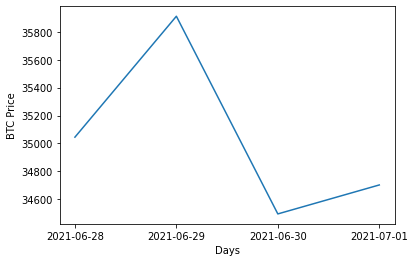

In [12]:
plt.plot(Days,df2['Price'])
plt.xlabel('Days')
plt.ylabel('BTC Price')
plt.show()

In [13]:
scaled_features = StandardScaler().fit_transform(df2[['Polarities', 'Price']])
#I Apply a standarScaler transformation on the Polarities and prices to compare them.

In [14]:

df2['Polarities'] = scaled_features[:,0]
df2['Price'] = scaled_features[:,1]

#del df2
#del df

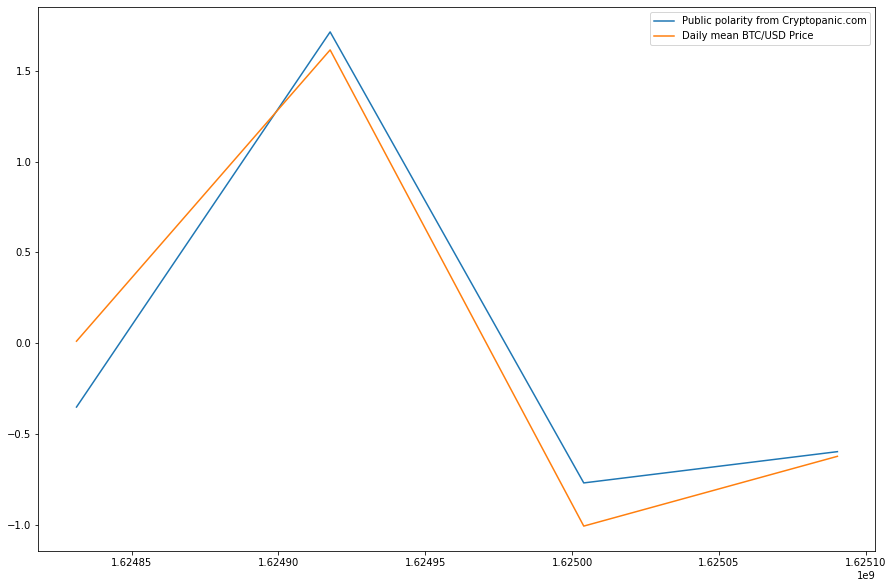

In [15]:
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(df2['Date'], df2['Polarities'], label='Public polarity from Cryptopanic.com')
plt.plot(df2['Date'], df2['Price'], label='Daily mean BTC/USD Price')
plt.legend()
plt.show()

We see an impressive correlation between price and public sentiment. We can calculate the Pearson coefficient to quantitatively estimate this correlation

In [16]:
from scipy.stats import pearsonr
print("Pearson correlation coefficient = {}".format(round(pearsonr(df2['Price'],df2['Polarities'])[0],3)))

Pearson correlation coefficient = 0.975


The idea now is to increase the frequency of retrieval of tweets from a daily basis to an hourly or minute basis and try to predict the price movement before it happens. This may not be possible, as the public probably only reacts to market movements and doesn't influence it.

Another goal is to avoid scraping tweets through cryptopanic.com, but directly from twitter.com, with a huge amount of data, we will have to perform data selection to keep only serious tweets. To do so, it would be great to train a new NLP Neural Network, specialized on bitcoin tweets.